This notebook is a basic algorithm to demonstrate the possibility to downscale a national logistical function to a regional level, even with a lack of data points at the regional level.

The problem that we often face is that, in one hand, we have a temporal data at the national level which can be fitted as a logistic function (as the number of cars per capita, or the number of housing m2, etc.), but on the other hand, we have the data at one year at the regional level.

Thus, the question is how to fuse a temporal-national dataset with a spatial-regional one ?

Here we show that we can infer regional logistical functions with only one data point at the regional level by an optimization method that tries to reproduce the national curve.

In [107]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [ ]:
# x is our "temporal" variable. It can serve either as time or as GDP/cap
x = np.linspace(0, 100)

In [ ]:
# definition of the 3 logistical parameters
k = 0.1 # the rate
s = 50  # the saturation
x0 = 50 # the inflection point

# definition of the ratio of the population of the two regions. The sum must be 1
a1 = 0.3
a2 = 0.7

In [ ]:
# definition of the two regional data points 
x1 = 45
y1 = 45
x2 = 75
y2 = 25

In [111]:
def logistic(x, s, k, x0):
    return s / (1 + np.exp(-k*(x-x0)))

In [112]:
def objective(vars):
    s1, x01, s2, x02 = vars
    y_true = logistic(x, s, k, x0)
    y_pred = a1*logistic(x, s1, k, x01) + a2*logistic(x, s2, k, x02)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [113]:
def constraint_eq_1(vars):
    s1, x01, s2, x02 = vars
    return logistic(x1, s1, k, x01) - y1  

def constraint_eq_2(vars):
    s1, x01, s2, x02 = vars
    return logistic(x2, s2, k, x02) - y2 

In [114]:
Ln = logistic(x, s, k, x0)

In [115]:
Lr1 = logistic(x, 60, k, 30)
Lr2 = logistic(x, 30, k, 60)

[]

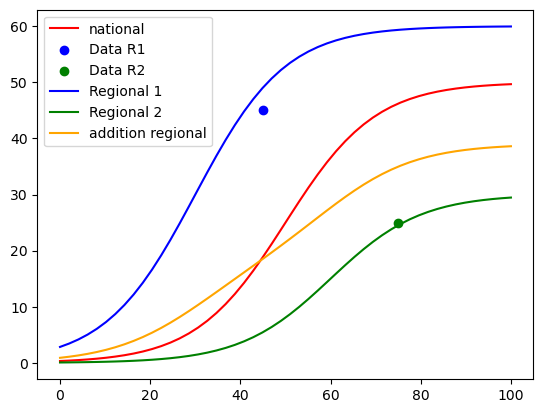

In [116]:
plt.plot(x, Ln, color="r", label="national")
plt.scatter(x1, y1, color="b", label="Data R1")
plt.scatter(x2, y2, color="g", label="Data R2")
plt.plot(x, Lr1, color="b", label="Regional 1")
plt.plot(x, Lr2, color="g", label="Regional 2")
plt.plot(x, a1*Lr1 + a2*Lr2, color="orange", label="addition regional")
plt.legend()
plt.plot()

In [117]:
# Combine the constraints
constraints = [
    {'type': 'eq', 'fun': constraint_eq_1},
    {'type': 'eq', 'fun': constraint_eq_2},
    {'type': 'ineq', 'fun': lambda vars: vars[0]}, # x >= 0
    {'type': 'ineq', 'fun': lambda vars: vars[1]},  # y >= 0
    {'type': 'ineq', 'fun': lambda vars: vars[2]}, # x >= 0
    {'type': 'ineq', 'fun': lambda vars: vars[3]},
]

In [118]:
# Initial guess
initial_guess = [s, x0, s, x0]

# Perform the optimization
opt = minimize(objective, initial_guess, constraints=constraints)

# Display the opt
if opt.success:
    print("Optimal solution:", opt.x)
    print("Objective function value:", opt.fun)
else:
    print("Optimization failed:", opt.message)

Optimal solution: [101.51729331  47.27884178  28.17721789  54.37130112]
Objective function value: 0.14436897297416942


[]

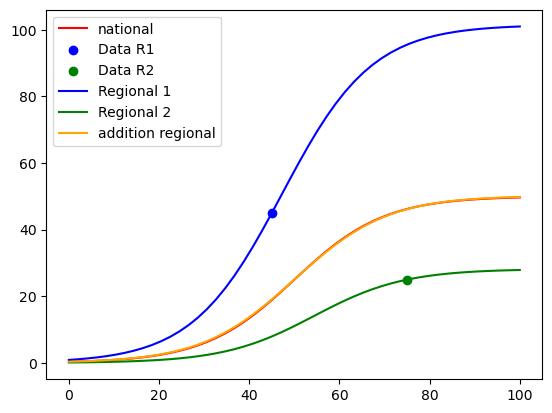

In [119]:
plt.plot(x, Ln, color="r", label="national")
plt.scatter(x1, y1, color="b", label="Data R1")
plt.scatter(x2, y2, color="g", label="Data R2")
plt.plot(x, logistic(x, opt.x[0], k, opt.x[1]), color="b", label="Regional 1")
plt.plot(x, logistic(x, opt.x[2], k, opt.x[3]), color="g", label="Regional 2")
plt.plot(x, a1*logistic(x, opt.x[0], k, opt.x[1]) + a2*logistic(x, opt.x[2], k, opt.x[3]), color="orange", label="addition regional")
plt.legend()
plt.plot()